In [19]:
from pathlib import Path
import sys


here = Path.cwd()
candidates = [here] + list(here.parents)
for p in candidates:
    if (p / "Code").is_dir():
        sys.path.insert(0, str(p))
        break
else:
    raise RuntimeError("Couldn't find a 'Code' folder in this project.")


import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd


from Code.PINN import create_network_model, u, compute_loss, g_trial_tf, make_train_step, compute_MSE
from Code.functions import euler, analytical_u


import seaborn as sns 
sns.set_theme(style="white", font_scale=1.3)
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["figure.dpi"] = 200
plt.rcParams.update({
    "savefig.dpi": 200,
    "savefig.bbox": "tight"
})

In [2]:
dx1 = 0.1
dt1 = 0.005        # stability limit: dt = dx^2 / 2 = 0.005
x1, t1, U1 = euler(dx1, dt1, T=0.2)

# Case 2: dx = 0.01
dx2 = 0.01
dt2 = 5e-5         # stability limit: dt = dx^2 / 2 = 5e-5
x2, t2, U2 = euler(dx2, dt2, T=0.2)

In [3]:
t1_val, t2_val = 0.01, 0.1


n1_1 = np.argmin(np.abs(t1 - t1_val))
n2_1 = np.argmin(np.abs(t1 - t2_val))

n1_2 = np.argmin(np.abs(t2 - t1_val))
n2_2 = np.argmin(np.abs(t2 - t2_val))


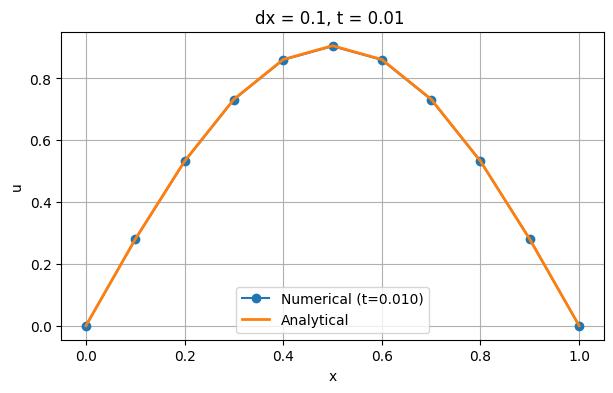

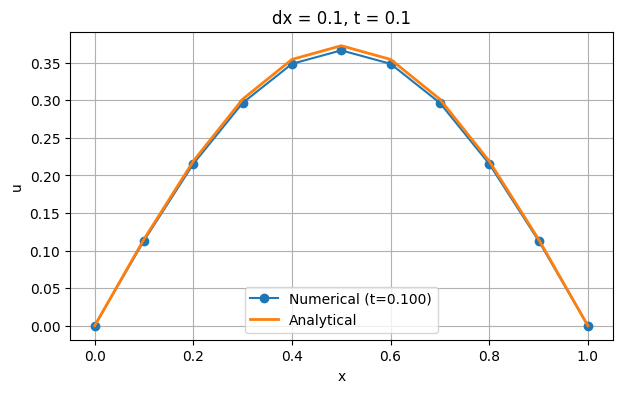

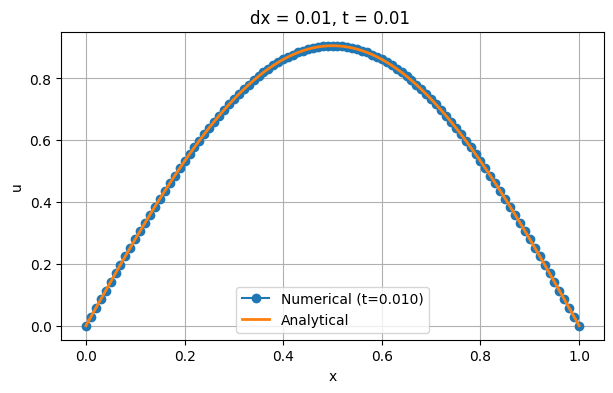

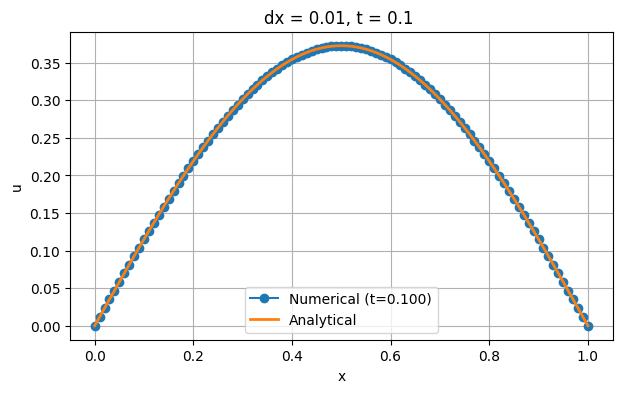

In [4]:
def plot_comparison(x, U, t_grid, n_idx, title):
    t_val = t_grid[n_idx]
    u_num = U[n_idx]
    u_exact = analytical_u(x, t_val)

    plt.figure(figsize=(7,4))
    plt.plot(x, u_num, 'o-', label=f"Numerical (t={t_val:.3f})")
    plt.plot(x, u_exact, '-', label="Analytical", lw=2)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("u")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_comparison(x1, U1, t1, n1_1, f"dx = {dx1}, t = {t1_val} ")
plot_comparison(x1, U1, t1, n2_1, f"dx = {dx1}, t = {t2_val}")

plot_comparison(x2, U2, t2, n1_2, f"dx = {dx2}, t = {t1_val} ")
plot_comparison(x2, U2, t2, n2_2, f"dx = {dx2}, t = {t2_val} ")

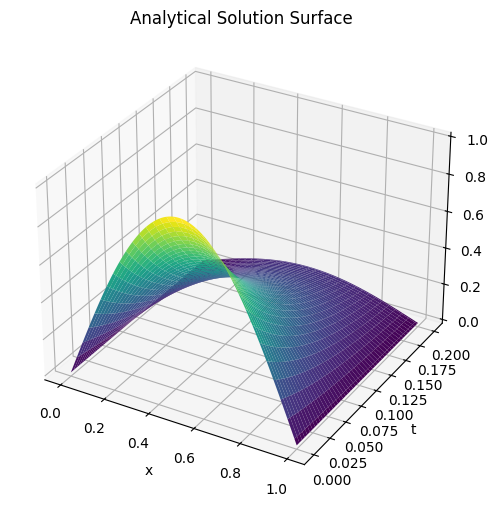

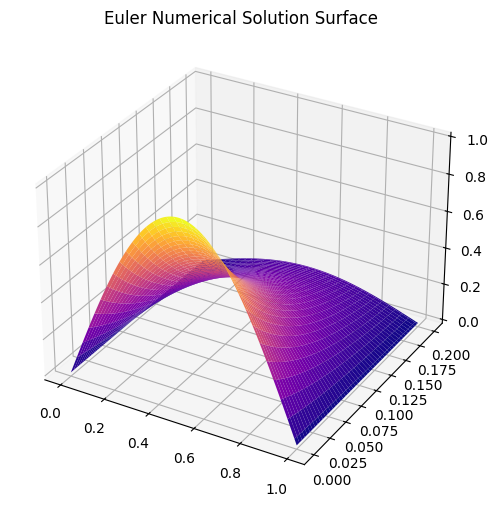

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Make a meshgrid
X, T = np.meshgrid(x2, t2)

# Analytical
U_exact = analytical_u(X, T)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, T, U_exact, cmap='viridis')
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u")
ax.set_title("Analytical Solution Surface")
plt.show()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, U_exact, cmap='plasma')
ax.set_title("Euler Numerical Solution Surface")
plt.show()


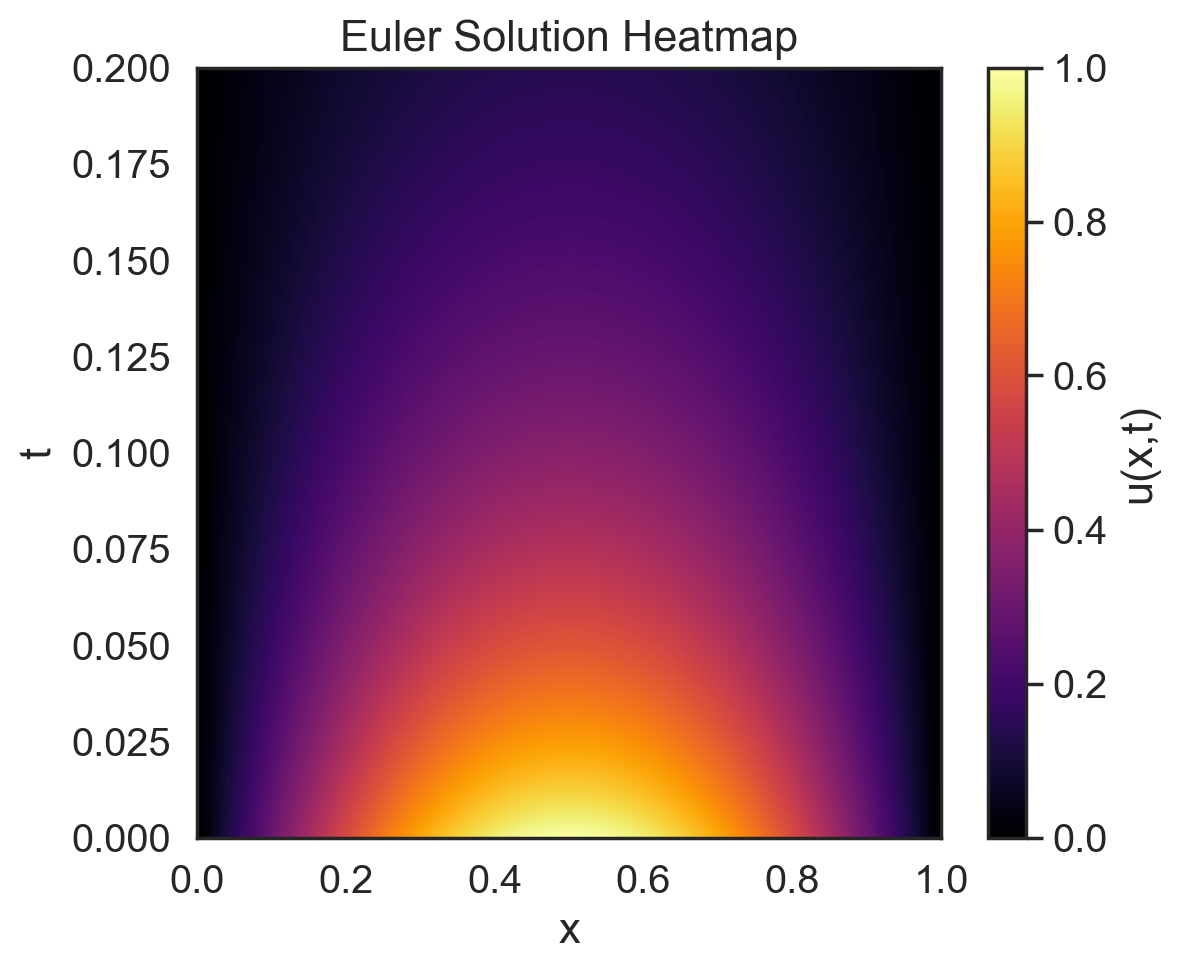

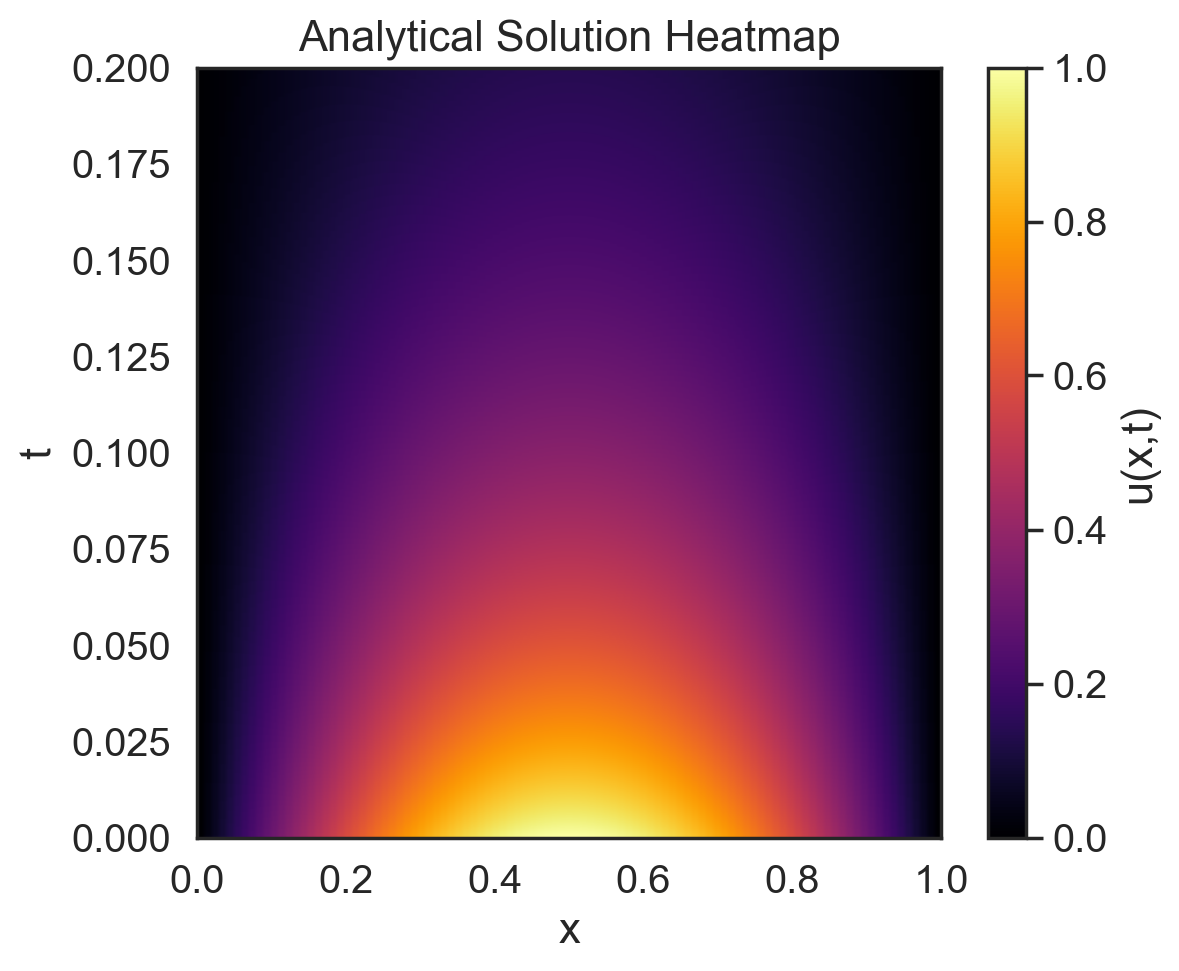

In [20]:
plt.figure(figsize=(6,5))
plt.imshow(U_exact, extent=[0,1,0,t2[-1]], origin='lower', aspect='auto', cmap='inferno')
plt.colorbar(label='u(x,t)')
plt.xlabel("x")
plt.ylabel("t")
plt.title("Euler Solution Heatmap")
plt.show()

U_exact = analytical_u(X, T)

plt.figure(figsize=(6,5))
plt.imshow(U_exact, extent=[0,1,0,t2[-1]], origin='lower', aspect='auto', cmap='inferno')
plt.colorbar(label='u(x,t)')
plt.title("Analytical Solution Heatmap")
plt.xlabel("x")
plt.ylabel("t")
plt.show()


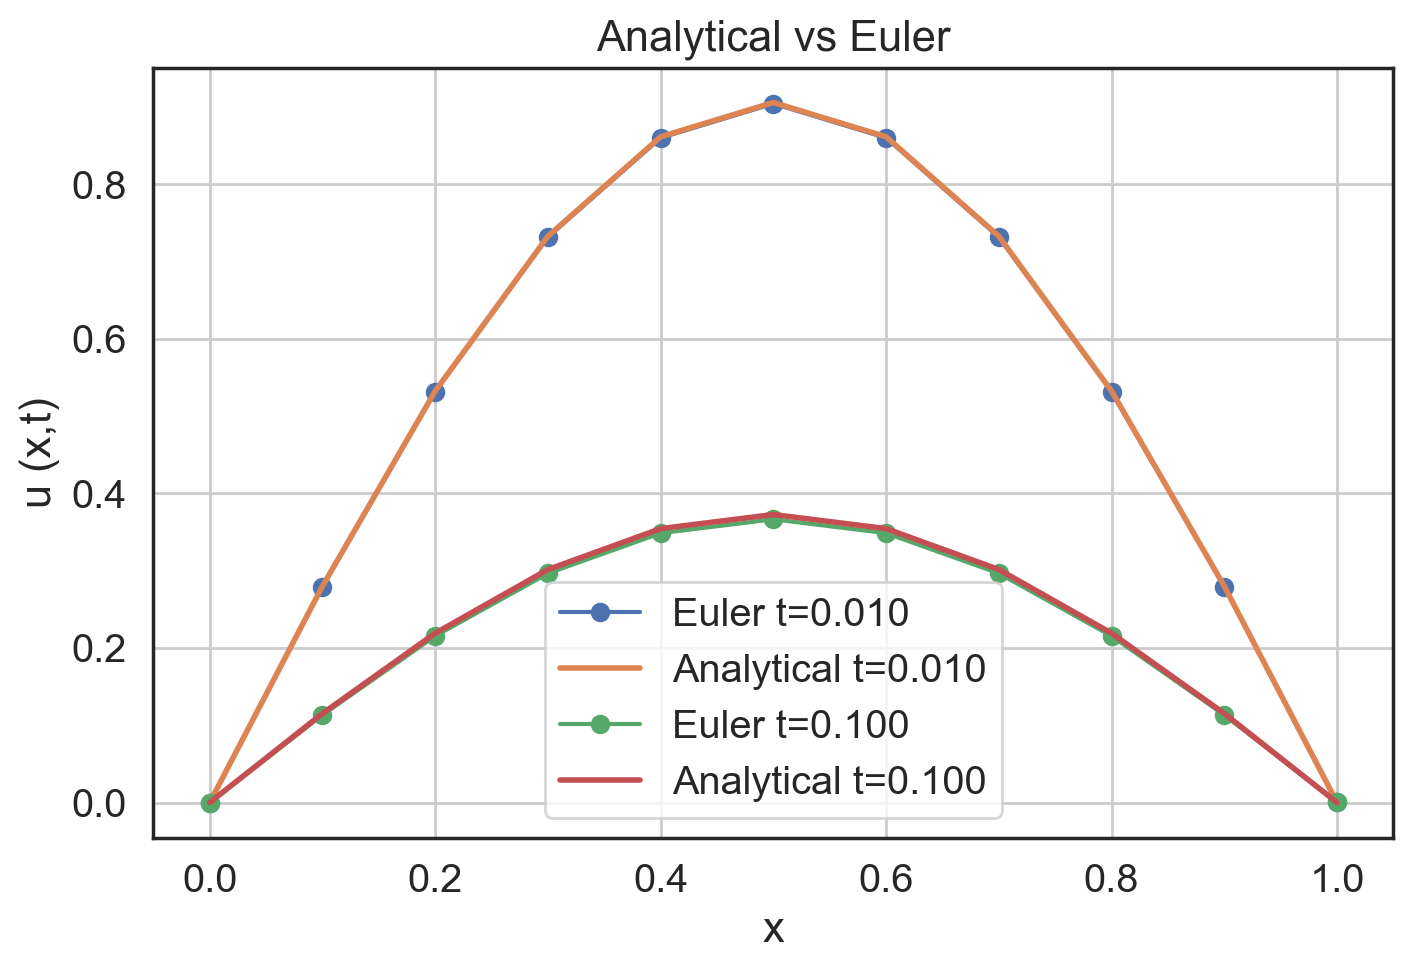

In [21]:
def compare_slices(x, U, t_grid, times):
    plt.figure(figsize=(8,5))

    for t_target in times:
        idx = np.argmin(np.abs(t_grid - t_target))
        t_val = t_grid[idx]

        plt.plot(x, U[idx], 'o-', label=f"Euler t={t_val:.3f}")
        plt.plot(x, analytical_u(x, t_val), '-', linewidth=2,
                 label=f"Analytical t={t_val:.3f}")

    plt.legend()
    plt.xlabel("x")
    plt.ylabel("u (x,t)")
    plt.grid(True)
    plt.title("Analytical vs Euler")
    plt.show()

compare_slices(x1, U1, t1, times=[0.01, 0.1])


In [8]:
NN_model = create_network_model(layers=[6, 7], activation='sigmoid')

2025-12-13 17:20:45.882343: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-12-13 17:20:45.882533: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-13 17:20:45.882542: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-12-13 17:20:45.882558: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-13 17:20:45.882569: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
N_points = 1000  # Number of collocation points (x, t) in the domain
epochs = 3000  # Number of training epochs
train_step = make_train_step(NN_model, optimizer, compute_loss)


T_final = 0.5 # Example final time
x_samples = np.random.uniform(0.0, 1.0, N_points)
t_samples = np.random.beta(3, 1, size=N_points) * T_final
X_train = np.stack([x_samples, t_samples], axis=1).astype(np.float32)

for epoch in range(epochs):
    current_loss = train_step(X_train)

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {current_loss.numpy():.6e}")


2025-12-13 17:20:46.391649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 50/3000, Loss: 8.309347e+00
Epoch 100/3000, Loss: 8.242236e+00
Epoch 150/3000, Loss: 8.166948e+00
Epoch 200/3000, Loss: 8.032654e+00
Epoch 250/3000, Loss: 7.803979e+00
Epoch 300/3000, Loss: 7.381618e+00
Epoch 350/3000, Loss: 6.065821e+00
Epoch 400/3000, Loss: 3.485571e+00
Epoch 450/3000, Loss: 2.000091e+00
Epoch 500/3000, Loss: 1.491153e+00
Epoch 550/3000, Loss: 1.175425e+00
Epoch 600/3000, Loss: 9.482626e-01
Epoch 650/3000, Loss: 7.770271e-01
Epoch 700/3000, Loss: 6.443089e-01
Epoch 750/3000, Loss: 5.368629e-01
Epoch 800/3000, Loss: 4.463589e-01
Epoch 850/3000, Loss: 3.703302e-01
Epoch 900/3000, Loss: 3.078900e-01
Epoch 950/3000, Loss: 2.566957e-01
Epoch 1000/3000, Loss: 2.170275e-01
Epoch 1050/3000, Loss: 1.883860e-01
Epoch 1100/3000, Loss: 1.671391e-01
Epoch 1150/3000, Loss: 1.503759e-01
Epoch 1200/3000, Loss: 1.364762e-01
Epoch 1250/3000, Loss: 1.245796e-01
Epoch 1300/3000, Loss: 1.141931e-01
Epoch 1350/3000, Loss: 1.050011e-01
Epoch 1400/3000, Loss: 9.678571e-02
Epoch 1450/3

In [ ]:
def pinn_solution(model, x, t_value):
    X_eval = np.stack([x, np.full_like(x, t_value)], axis=1).astype(np.float32)
    N_out = model(X_eval)
    g_val = g_trial_tf(tf.constant(X_eval, dtype=tf.float32), model, N_out)
    return g_val.numpy().flatten()



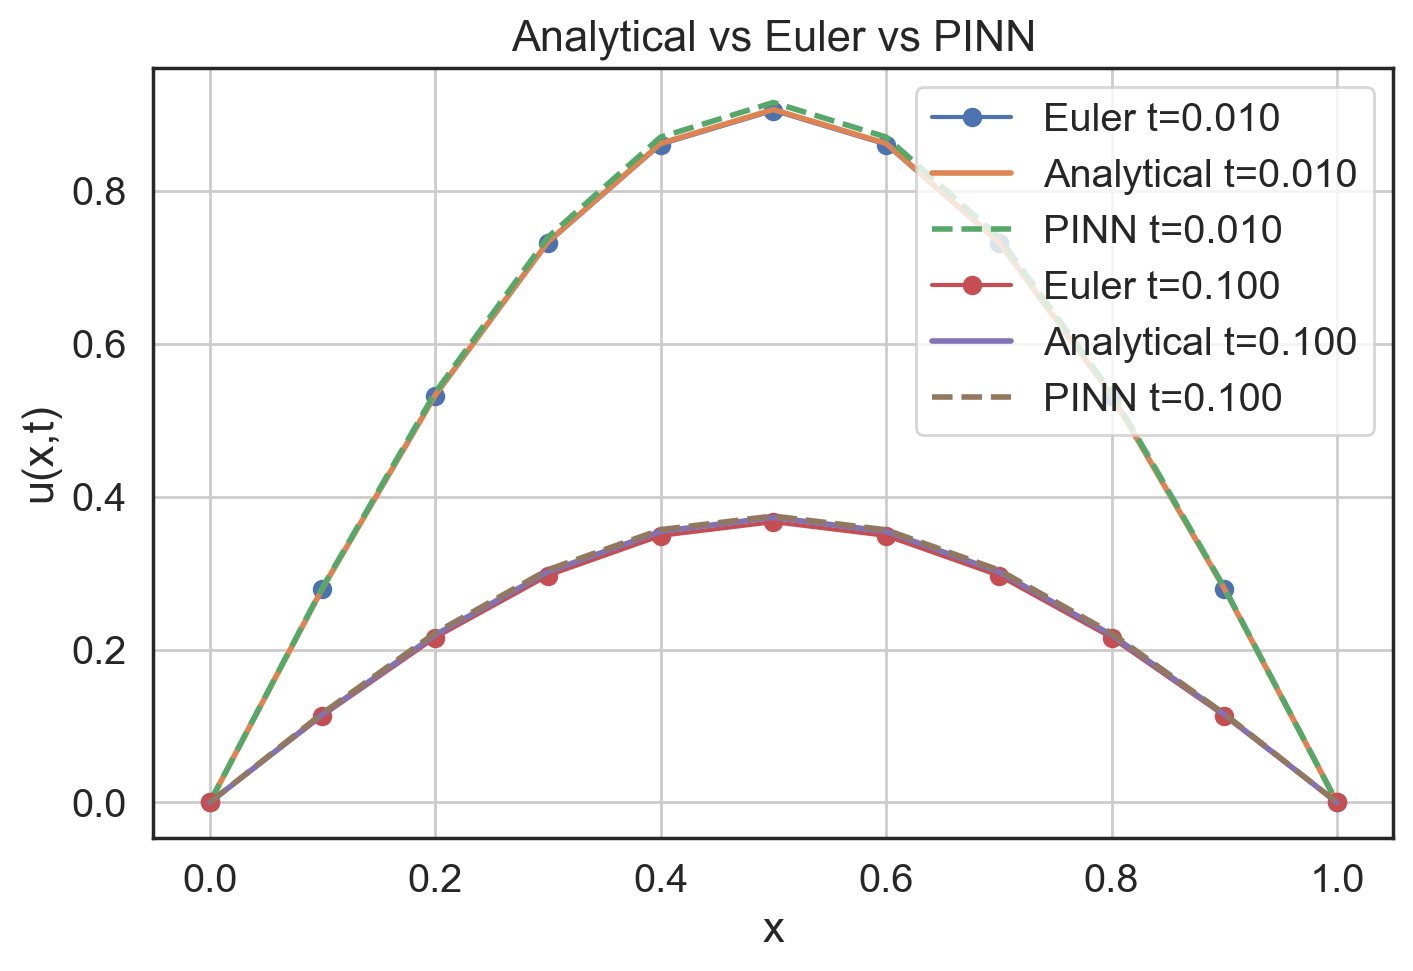

In [22]:
def compare_slices_with_pinn(x, U, t_grid, times, NN_model):
    plt.figure(figsize=(8,5))

    for t_target in times:
        idx = np.argmin(np.abs(t_grid - t_target))
        t_val = t_grid[idx]

        # Euler FD
        plt.plot(x, U[idx], 'o-', label=f"Euler t={t_val:.3f}")

        # Analytical
        plt.plot(x, analytical_u(x, t_val), '-', linewidth=2,
                 label=f"Analytical t={t_val:.3f}")

        # PINN
        u_pinn = pinn_solution(NN_model, x, t_val)
        plt.plot(x, u_pinn, '--', linewidth=2,
                 label=f"PINN t={t_val:.3f}")

    plt.legend()
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.grid(True)
    plt.title("Analytical vs Euler vs PINN")
    plt.show()

compare_slices_with_pinn(x1, U1, t1, times=[0.01, 0.1], NN_model=NN_model)


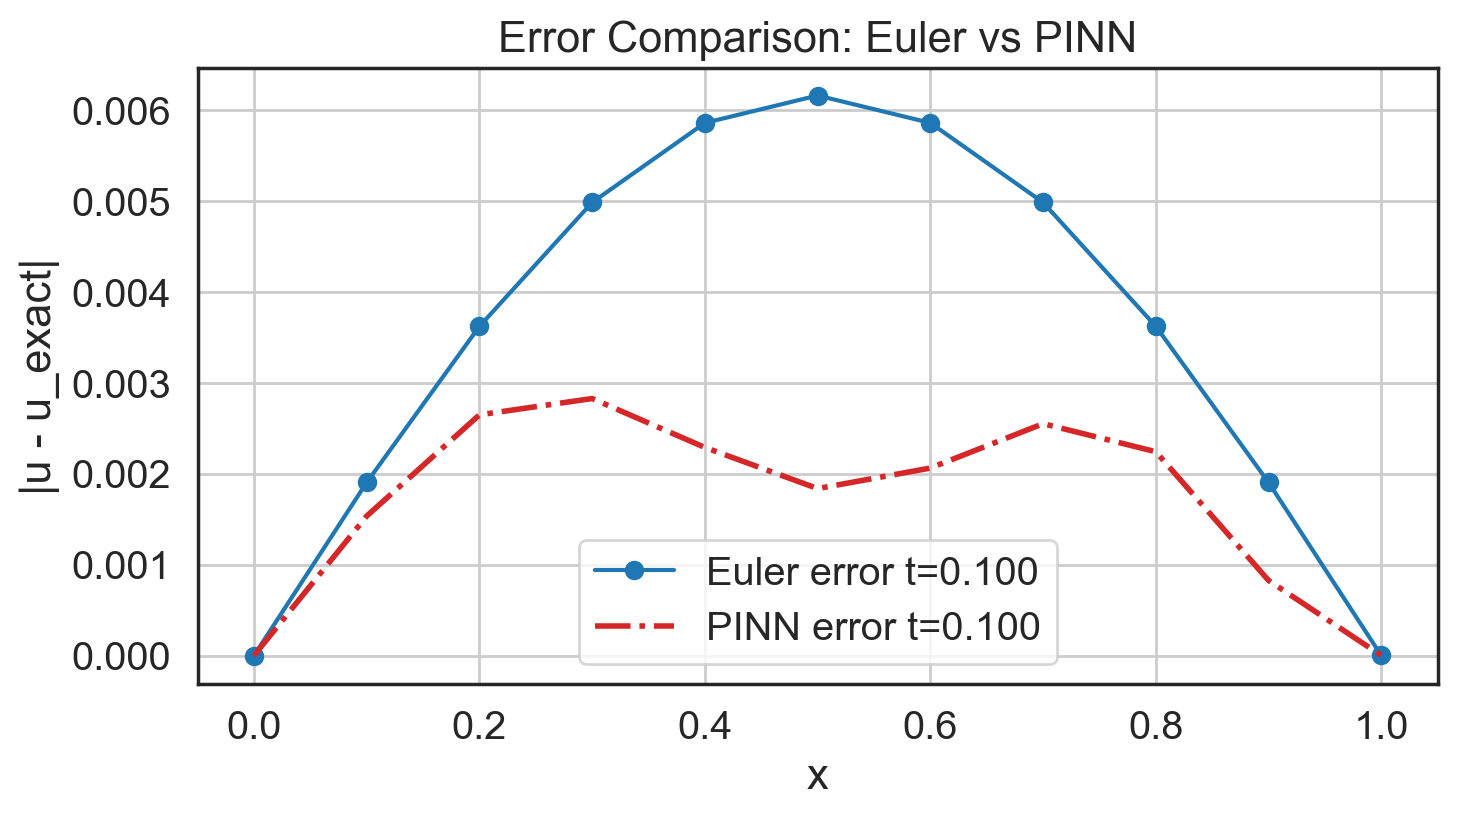

In [28]:
def plot_errors(x, U, t_grid, t_target, NN_model):
    idx = np.argmin(np.abs(t_grid - t_target))
    t_val = t_grid[idx]

    u_exact = analytical_u(x, t_val)
    u_euler = U[idx]
    u_pinn  = pinn_solution(NN_model, x, t_val)

    e_euler = np.abs(u_euler - u_exact)
    e_pinn  = np.abs(u_pinn - u_exact)

    plt.figure(figsize=(8,4))
    plt.plot(x, e_euler, 'o-', label=f"Euler error t={t_val:.3f}", color="tab:blue")
    plt.plot(x, e_pinn,  '-.', label=f"PINN error t={t_val:.3f}", color="tab:red", linewidth=2)

    plt.xlabel("x")
    plt.ylabel("|u - u_exact|")
    plt.title("Error Comparison: Euler vs PINN")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_errors(x1, U1, t1, t_target=0.1, NN_model=NN_model)


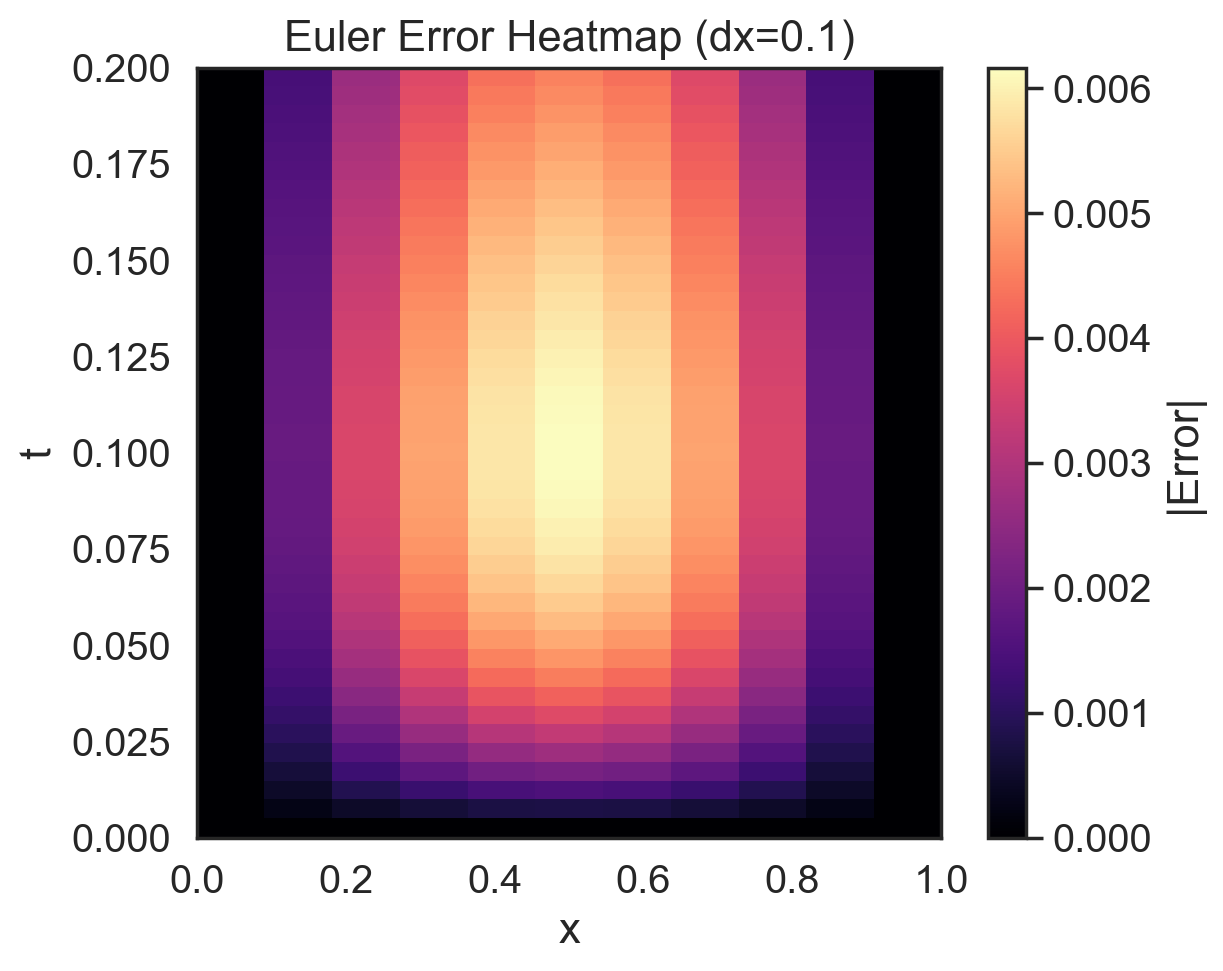

In [24]:
def heatmap_error(x, t, U, title):
    X, T = np.meshgrid(x, t)
    U_exact = analytical_u(X, T)
    error = np.abs(U - U_exact)

    plt.figure(figsize=(6,5))
    plt.imshow(error, extent=[0,1,0,t[-1]], origin='lower',
               aspect='auto', cmap='magma')
    plt.colorbar(label="|Error|")
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("t")
    plt.show()

heatmap_error(x1, t1, U1, "Euler Error Heatmap (dx=0.1)")


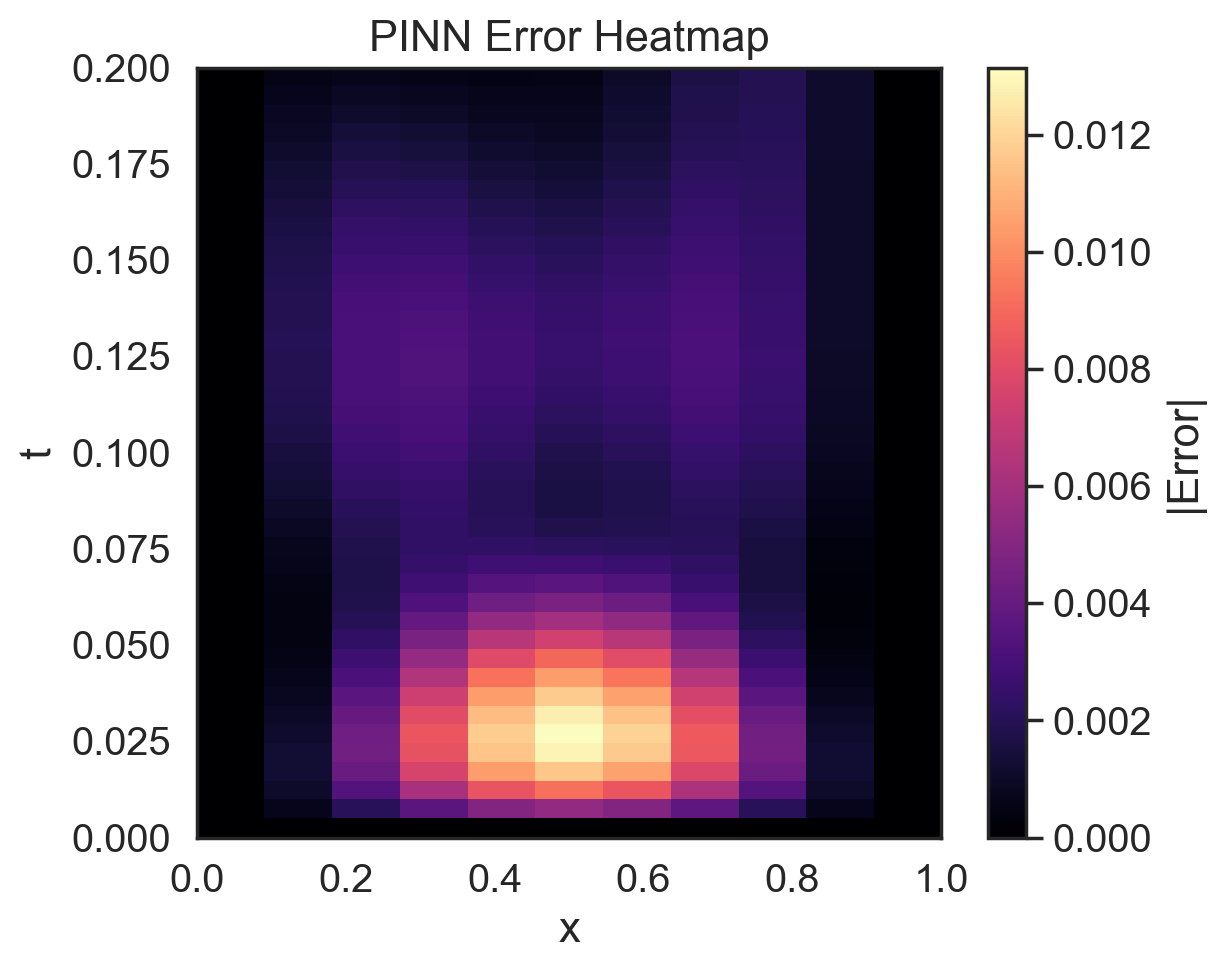

In [25]:
def pinn_error_heatmap(x, t, NN_model):
    X, T = np.meshgrid(x, t)
    U_exact = analytical_u(X, T)
    U_pinn = np.zeros_like(U_exact)

    for i, t_val in enumerate(t):
        U_pinn[i] = pinn_solution(NN_model, x, t_val)

    error = np.abs(U_pinn - U_exact)

    plt.figure(figsize=(6,5))
    plt.imshow(error, extent=[0,1,0,t[-1]], origin='lower',
               aspect='auto', cmap='magma')
    plt.colorbar(label="|Error|")
    plt.title("PINN Error Heatmap")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.show()


pinn_error_heatmap(x1, t1, NN_model)

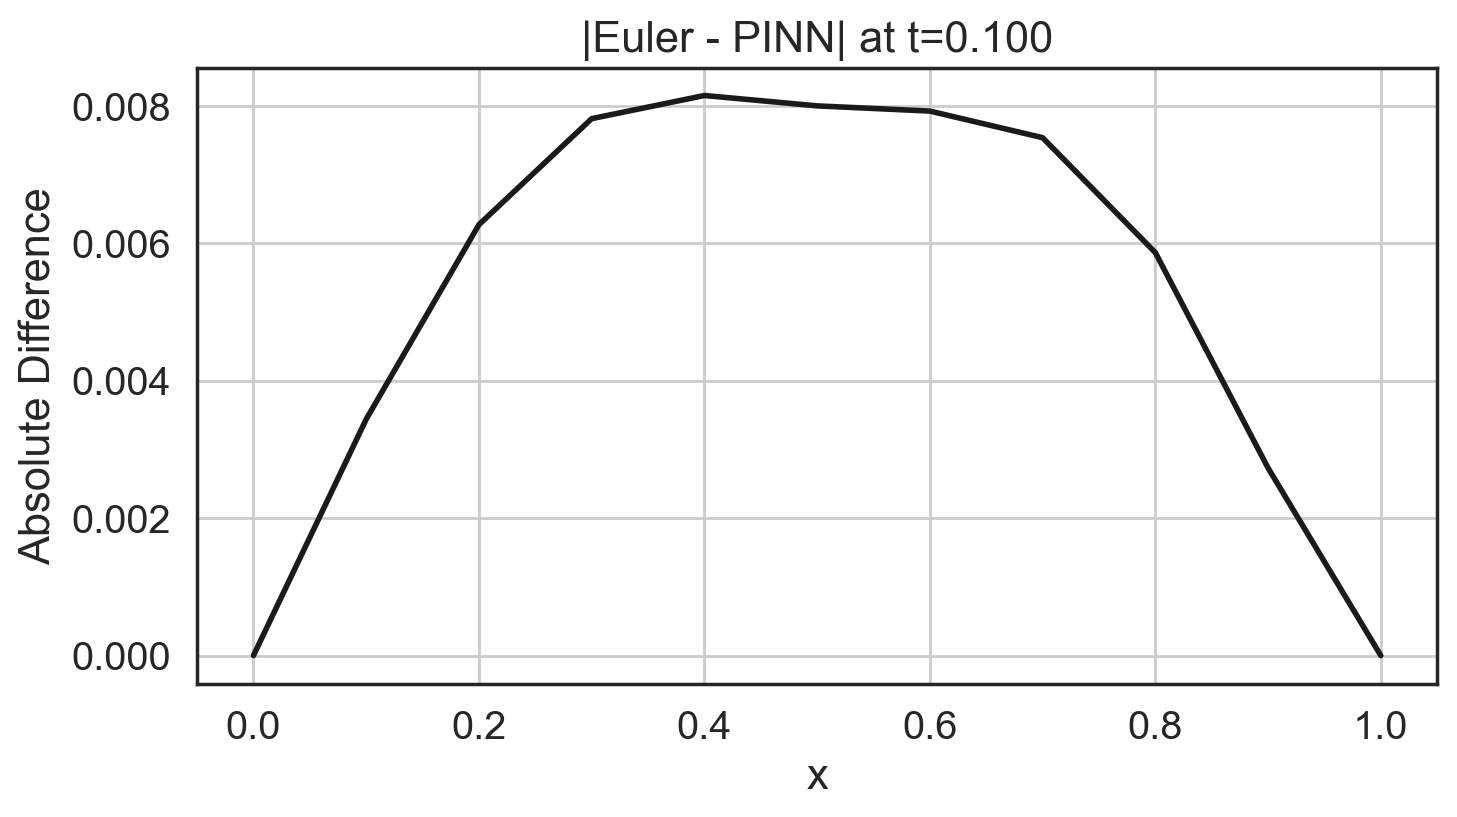

In [26]:
def compare_euler_pinn_error(x, U, t_grid, t_target, NN_model):
    idx = np.argmin(np.abs(t_grid - t_target))
    t_val = t_grid[idx]

    u_euler = U[idx]
    u_pinn  = pinn_solution(NN_model, x, t_val)

    diff = np.abs(u_euler - u_pinn)

    plt.figure(figsize=(8,4))
    plt.plot(x, diff, 'k-', linewidth=2)
    plt.title(f"|Euler - PINN| at t={t_val:.3f}")
    plt.xlabel("x")
    plt.ylabel("Absolute Difference")
    plt.grid(True)
    plt.show()

compare_euler_pinn_error(x1, U1, t1, t_target=0.1, NN_model=NN_model)

In [29]:
def plot_long_time(x, U, t_grid, t_target, NN_model):
    idx = np.argmin(np.abs(t_grid - t_target))
    t_val = t_grid[idx]

    # Solutions
    u_exact = analytical_u(x, t_val)
    u_euler = U[idx]
    u_pinn  = pinn_solution(NN_model, x, t_val)

    # Plot
    plt.figure(figsize=(7,4))
    plt.plot(x, u_exact, 'k-', lw=2, label=f"Analytical t={t_val:.3f}")
    plt.plot(x, u_euler, 'o-', lw=1.5, label=f"Euler t={t_val:.3f}")
    plt.plot(x, u_pinn, '--', lw=2, label=f"PINN t={t_val:.3f}")

    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.title("Long-Time Comparison: Euler vs PINN vs Analytical")
    plt.grid(True)
    plt.legend()
    plt.show()


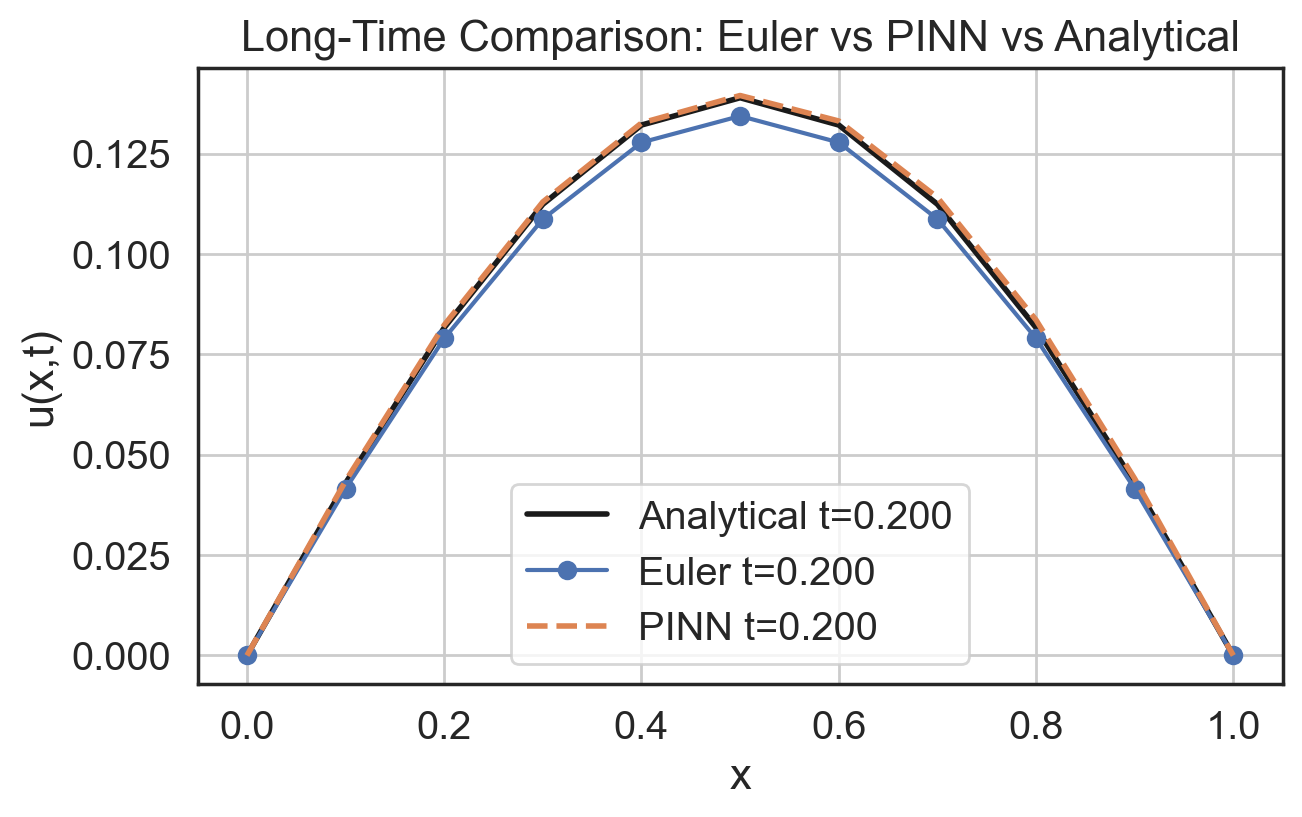

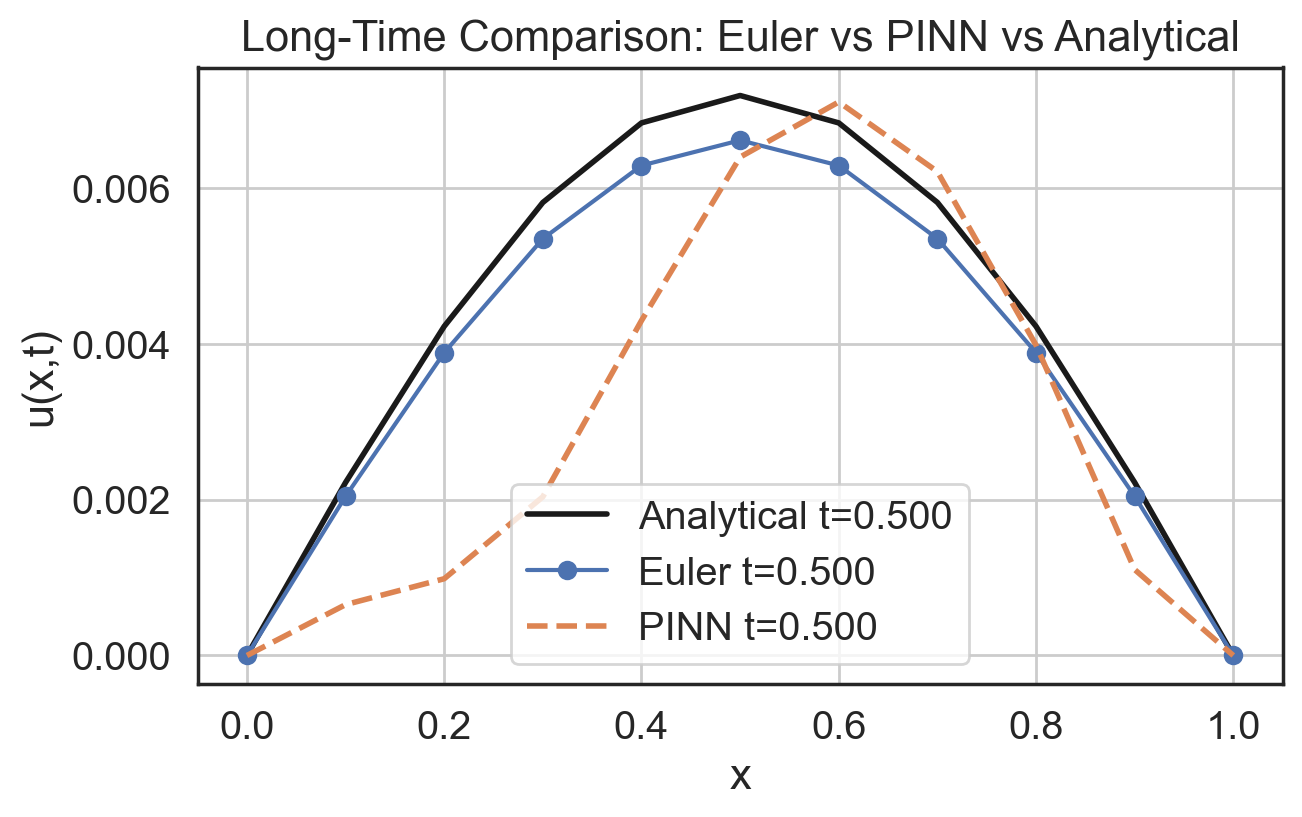

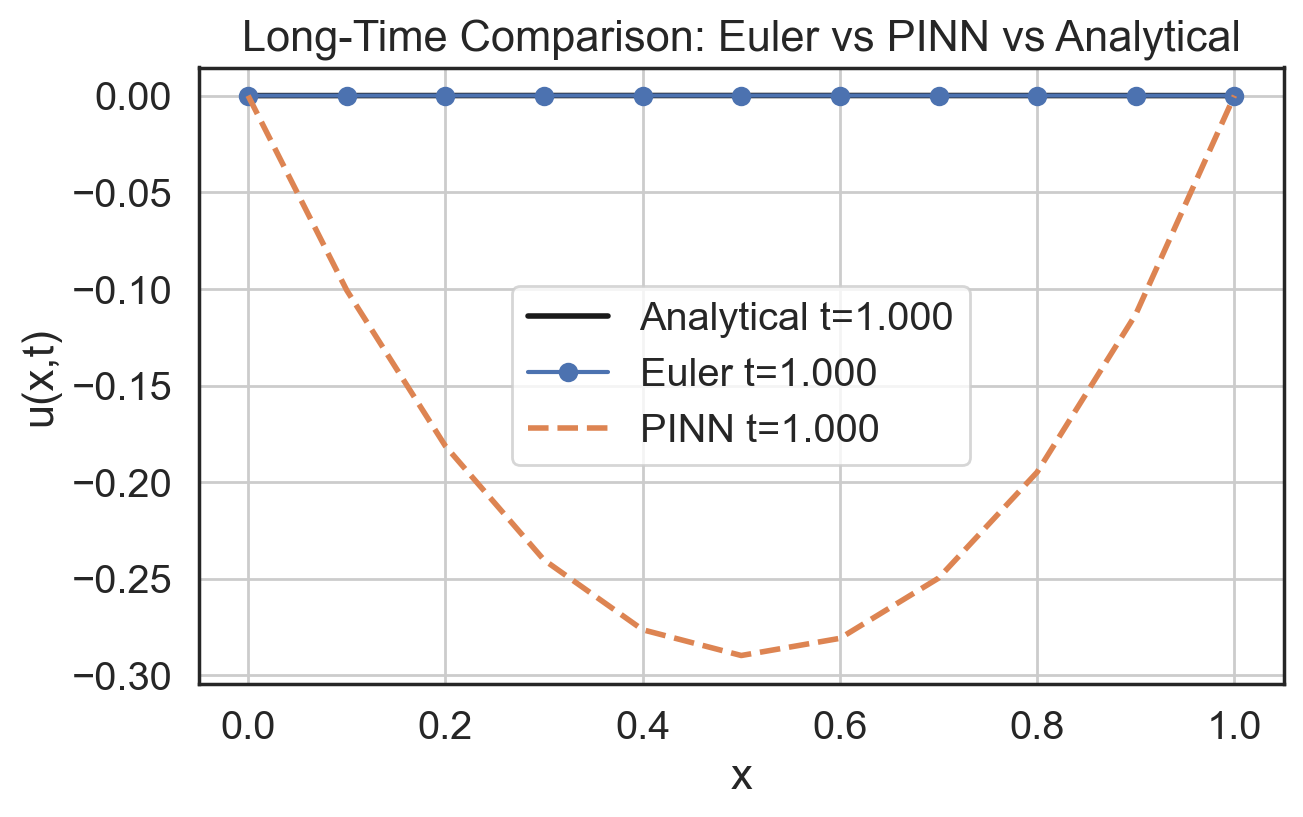

In [32]:
x1, t1, U1 = euler(dx1, dt1, T=1)

plot_long_time(x1, U1, t1, t_target=0.2, NN_model=NN_model)
plot_long_time(x1, U1, t1, t_target=0.5, NN_model=NN_model)
plot_long_time(x1, U1, t1, t_target=1, NN_model=NN_model)
